In [ ]:
! pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.7 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.7/425.7 kB 27.6 MB/s eta 0:00

In [1]:
# LIBRERÍAS Y AGENTE
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams["animation.embed_limit"] = 2**128

import numpy as np

class FireFighterAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.lifting = False  # Estado que indica si el agente está cargando una víctima
        self.path = []  # Lista que almacena el camino hacia el POI
        self.steps_taken = 0  # Contador de pasos dados por el agente
        self.action_points = 4  # Puntos de Acción iniciales del agente
        self.state = 'searching'  # Inicialmente, todos los agentes buscan POIs
        self.target_poi = None



    #     # print(f"Agente {self.unique_id} comienza iteración {self.steps_taken} con {self.action_points} puntos de acción")

    # def can_move(self, current_pos, target_pos):
    #     """Verifica si el agente puede moverse desde la celda actual a la celda objetivo."""
    #     x1, y1 = current_pos
    #     x2, y2 = target_pos

    #     # Verifica si el movimiento es hacia arriba
    #     if x2 < x1:
    #         return self.model.walls_grid[x1][y1][0] in ['door', 'entrance', 0] and self.model.walls_grid[x2][y2][2] in ['door', 'entrance', 0]

    #     # Verifica si el movimiento es hacia la derecha
    #     elif y2 > y1:
    #         return self.model.walls_grid[x1][y1][1] in ['door', 'entrance', 0] and self.model.walls_grid[x2][y2][3] in ['door', 'entrance', 0]

    #     # Verifica si el movimiento es hacia abajo
    #     elif x2 > x1:
    #         return self.model.walls_grid[x1][y1][2] in ['door', 'entrance', 0] and self.model.walls_grid[x2][y2][0] in ['door', 'entrance', 0]

    #     # Verifica si el movimiento es hacia la izquierda
    #     elif y2 < y1:
    #         return self.model.walls_grid[x1][y1][3] in ['door', 'entrance', 0] and self.model.walls_grid[x2][y2][1] in ['door', 'entrance', 0]

    #     return False  # Si no es un movimiento válido, retornar False

    # def move_to(self, pos):
    #     """Mueve el agente a la posición objetivo si es seguro y permitido."""

    #     cost = 1

    #     # Verificar si la celda objetivo tiene fuego
    #     if self.model.fires_grid[pos[0]][pos[1]] == 2:
    #         cost = 2
    #         print(f"Agente {self.unique_id} esta parado en una celda de fuego")

    #     # Verificar si el agente no está cargando y pasa por el humo
    #     elif self.model.fires_grid[pos[0]][pos[1]] == 1 and self.lifting:
    #         cost = 2

    #     elif self.model.fires_grid[pos[0]][pos[1]] == 0 and self.lifting:
    #         cost = 2



    #     # Verificar si el agente tiene suficientes Puntos de Acción para moverse
    #     if self.action_points >= cost:
    #         print("El costo es de ", cost)
    #         self.action_points -= cost  # Reducir los Puntos de Acción en función del costo del movimiento
    #         print(f"Agente {self.unique_id} tiene {self.action_points} puntos de acción")
    #         self.model.grid.move_agent(self, pos)  # Mover el agente a la posición objetivo
    #         print(f"Agente {self.unique_id} se movió a {pos}. Quedan {self.action_points} puntos de acción.")
    #         return True
    #     return False



    # def extinguish_fire(self, current_pos, target_pos):
    #     """Apaga el fuego en la celda objetivo si está adyacente y el agente tiene suficientes puntos de acción."""
    #     x1, y1 = current_pos
    #     x2, y2 = target_pos

    #     if can_move(current_pos, target_pos):

    #       # Verificar si la celda objetivo está adyacente a la posición actual
    #       if abs(x1 - x2) + abs(y1 - y2) == 1 and self.model.fires_grid[x2][y2] == 2:
    #           cost = 2

    #           # Verificar si el agente tiene suficientes Puntos de Acción para apagar el fuego
    #           if self.action_points >= cost:
    #               self.action_points -= cost  # Reducir los Puntos de Acción
    #               self.model.fires_grid[x2][y2] = 0  # Apagar el fuego (cambiar a estado 0)
    #               print(f"Agente {self.unique_id} apagó el fuego en {target_pos}. Quedan {self.action_points} puntos de acción.")
    #               return True
    #     return False


    # def extinguish_fire(self, current_pos, target_pos):
    #   """Apaga el fuego en la celda objetivo si está adyacente y el agente tiene suficientes puntos de acción."""
    #   x1, y1 = current_pos
    #   x2, y2 = target_pos

    #   if can_move(current_pos, target_pos):

    #     # Verificar si la celda objetivo está adyacente a la posición actual
    #     if abs(x1 - x2) + abs(y1 - y2) == 1 and self.model.fires_grid[x2][y2] == 2:
    #         cost = 2

    #         # Verificar si el agente tiene suficientes Puntos de Acción para apagar el fuego
    #         if self.action_points >= cost:
    #             self.action_points -= cost  # Reducir los Puntos de Acción
    #             self.model.fires_grid[x2][y2] = 0  # Apagar el fuego (cambiar a estado 0)
    #             print(f"Agente {self.unique_id} apagó el fuego en {target_pos}. Quedan {self.action_points} puntos de acción.")
    #             return True
    #   return False

    # def break_walls(self, current_pos, target_pos):

    #   x1, y1 = current_pos
    #   x2, y2 = target_pos

    #   # Verificar la dirección del movimiento
    #   if x1 == x2:  # Movimiento horizontal
    #       if y2 > y1:  # Movimiento hacia la derecha
    #           self.model.walls_grid[x1][y1][2] -= 1  # Resta a la pared derecha de la celda actual
    #           self.model.walls_grid[x2][y2][0] -= 1  # Resta a la pared izquierda de la celda destino
    #       else:  # Movimiento hacia la izquierda
    #           self.model.walls_grid[x1][y1][0] -= 1  # Resta a la pared izquierda de la celda actual
    #           self.model.walls_grid[x2][y2][2] -= 1  # Resta a la pared derecha de la celda destino
    #   elif y1 == y2:  # Movimiento vertical
    #       if x2 > x1:  # Movimiento hacia abajo
    #           self.model.walls_grid[x1][y1][1] -= 1  # Resta a la pared inferior de la celda actual
    #           self.model.walls_grid[x2][y2][3] -= 1  # Resta a la pared superior de la celda destino
    #       else:  # Movimiento hacia arriba
    #           self.model.walls_grid[x1][y1][3] -= 1  # Resta a la pared superior de la celda actual
    #           self.model.walls_grid[x2][y2][1] -= 1  # Resta a la pared inferior de la celda destino




    # def find_safe_move(self):
    #   """Encuentra todas las celdas vecinas seguras a las que el agente puede moverse."""
    #   neighbors = self.model.grid.get_neighborhood(
    #       self.pos, moore=False, include_center=False)

    #   # Filtrar celdas según el estado del agente y la presencia de paredes
    #   if self.lifting or self.action_points <= 2:
    #       # Si está cargando una víctima o tiene <= 2 puntos de acción, evitar celdas con fuego de valor 2
    #       print(f"Agente {self.unique_id} tiene {self.action_points} action points (-=2)")
    #       safe_moves = [pos for pos in neighbors if self.model.fires_grid[pos[0]][pos[1]] <= 1 and self.can_move(self.pos, pos)]
    #   else:
    #       # Si no está cargando una víctima y tiene > 2 puntos de acción, permitir celdas con fuego de valor 2
    #       safe_moves = [pos for pos in neighbors if self.model.fires_grid[pos[0]][pos[1]] >= 0 and self.can_move(self.pos, pos)]
    #       print(f"Agente {self.unique_id} tiene {self.action_points} action points (+2)")

    #   return safe_moves  # Retornar la lista de movimientos seguros


    # # def step(self):
    # #   """Define el comportamiento del agente en cada paso del modelo."""
    # #   self.steps_taken += 1  # Incrementar el contador de pasos en cada turno
    # #   self.action_points = 4  # Reiniciar los Puntos de Acción al comienzo de cada turno

    # #   # Intentar moverse a una celda segura
    # #   no_moves = True
    # #   while self.action_points > 0 and no_moves:
    # #       safe_moves = self.find_safe_move()
    # #       print(f"Agente {self.unique_id} esta en {self.pos} y encontro espacios seguros {safe_moves}")
    # #       if safe_moves:
    # #           target_move = self.random.choice(safe_moves)  # Elegir aleatoriamente un movimiento seguro
    # #           # print(f"Agente {self.unique_id} esta en la celda {self.pos}")
    # #           self.move_to(target_move)  # Mover el agente a la celda seleccionada
    # #           # print(f"Agente {self.unique_id} se movió a {target_move}. Quedan {self.action_points} puntos de acción.")
    # #       else:
    # #           # print(f"Agente {self.unique_id} termina iteración {self.steps_taken} ya no tiene sus action points {self.action_points}.")
    # #           no_moves = False  # No hay movimientos seguros disponibles


    # def find_nearest_poi(self):
    #   # Obtiene todas las coordenadas (x, y) en la cuadrícula de puntos de interés (POI)
    #   # donde el valor en la cuadrícula es mayor que 0 (indica que hay un POI en esa posición)
    #   pois = [(x, y) for (x, y) in np.ndindex(self.model.poi_grid.shape) if self.model.poi_grid[x][y] > 0]

    #   # Si no hay POIs disponibles, retorna None
    #   if not pois:
    #       return None

    #   # Encuentra y retorna el POI más cercano a la posición actual del agente.
    #   # Utiliza la distancia de Manhattan para calcular la cercanía.
    #   return min(pois, key=lambda poi: abs(self.pos[0] - poi[0]) + abs(self.pos[1] - poi[1]))

    # def find_nearest_entrance(self):
    #     # Obtiene todas las coordenadas (x, y) en la cuadrícula de entradas
    #     entrances = [(x, y) for (x, y) in np.ndindex(self.model.walls_grid.shape)
    #                 if 'entrance' in self.model.walls_grid[x][y]]

    #     # Si no hay entradas disponibles, retorna None
    #     if not entrances:
    #         return None

    #     # Encuentra y retorna la entrada más cercana a la posición actual del agente.
    #     return min(entrances, key=lambda entrance: abs(self.pos[0] - entrance[0]) + abs(self.pos[1] - entrance[1]))

    # def get_path(self, poi_pos):

    #     # Convierte la posición actual del agente y la posición objetivo del POI a arrays de numpy
    #     current_pos = np.array(self.pos)
    #     target_pos = np.array(poi_pos)

    #     # Inicializa una lista para almacenar el camino desde la posición actual hasta el POI
    #     path = []

    #     # Repite hasta que la posición actual sea igual a la posición objetivo (es decir, se haya alcanzado el POI)
    #     while not np.array_equal(current_pos, target_pos):
    #         # Calcula la dirección del siguiente paso hacia el POI (puede ser -1, 0 o 1 en cada eje)
    #         step_direction = np.sign(target_pos - current_pos)

    #         # Determina la siguiente posición sumando la dirección calculada a la posición actual
    #         next_pos = current_pos + step_direction

    #         # Añade la siguiente posición al camino
    #         path.append(tuple(next_pos))

    #         # Actualiza la posición actual a la nueva posición calculada
    #         current_pos = next_pos

    #     # Retorna la lista completa de posiciones que forman el camino hacia el POI
    #     return path

    # def step(self):
    #     # Incrementa el contador de pasos del agente en cada paso del modelo
    #     self.steps_taken += 1

    #     # Asigna 4 puntos de acción para este paso del agente
    #     self.action_points = 4

    #     # Verifica el estado actual del agente
    #     if self.state == 'searching':

    #       if self.path == []:
    #         # Encuentra el punto de interés (POI) más cercano
    #         poi = self.find_nearest_poi()
    #         if poi:
    #             # Calcula el camino hacia el POI y lo almacena
    #             self.path = self.get_path(poi)
    #             # Inicializa el índice del camino
    #             self.path_index = 0
    #             # Cambia el estado a 'moving_to_poi' para comenzar a moverse hacia el POI

    #     # Verifica si hay más puntos en el camino por recorrer
    #       self.path_index < len(self.path):
    #           # Obtiene la siguiente posición en el camino
    #           next_pos = self.path[self.path_index]
    #           # Mueve el agente a la siguiente posición
    #           if self.move_to(next_pos):
    #               # Avanza al siguiente punto del camino si el movimiento es exitoso
    #               self.path_index += 1
    #           # Si el agente ha llegado al final del camino
    #           if self.pos == self.path[-1]:
    #               # Procesa el POI en la posición actual
    #               self.model.poi_grid[self.pos[0]][self.pos[1]] = 0
    #               # Marca que el agente ha levantado la víctima
    #               self.lifted = True
    #               # Cambia el estado a 'heading_to_entrance' para moverse hacia la entrada
    #               self.path = []
    #               self.state = 'heading_to_entrance'
    #       else:
    #           # Si ya no hay puntos en el camino, vuelve a buscar POIs
    #           self.state = 'searching'



    #     elif self.state == 'moving_to_poi':
    #         # Verifica si hay más puntos en el camino por recorrer
    #         if self.path_index < len(self.path):
    #             # Obtiene la siguiente posición en el camino
    #             next_pos = self.path[self.path_index]
    #             # Mueve el agente a la siguiente posición
    #             if self.move_to(next_pos):
    #                 # Avanza al siguiente punto del camino si el movimiento es exitoso
    #                 self.path_index += 1
    #             # Si el agente ha llegado al final del camino
    #             if self.pos == self.path[-1]:
    #                 # Procesa el POI en la posición actual
    #                 self.model.poi_grid[self.pos[0]][self.pos[1]] = 0
    #                 # Marca que el agente ha levantado la víctima
    #                 self.lifted = True
    #                 # Cambia el estado a 'heading_to_entrance' para moverse hacia la entrada
    #                 self.state = 'heading_to_entrance'
    #         else:
    #             # Si ya no hay puntos en el camino, vuelve a buscar POIs
    #             self.state = 'searching'

    #     elif self.state == 'heading_to_entrance':
    #         # Encuentra la entrada más cercana
    #         entrance = self.find_nearest_entrance()
    #         if entrance:
    #             # Calcula el camino hacia la entrada y lo almacena
    #             self.path = self.get_path(entrance)
    #             # Inicializa el índice del camino
    #             self.path_index = 0
    #             # Cambia el estado a 'moving_to_entrance' para comenzar a moverse hacia la entrada
    #             self.state = 'moving_to_entrance'
    #         else:
    #             # Si no se encuentra una entrada, vuelve a buscar POIs
    #             self.state = 'searching'

    #     elif self.state == 'moving_to_entrance':
    #         # Verifica si hay más puntos en el camino hacia la entrada por recorrer
    #         if self.path_index < len(self.path):
    #             # Obtiene la siguiente posición en el camino
    #             next_pos = self.path[self.path_index]
    #             # Mueve el agente a la siguiente posición
    #             if self.move_to(next_pos):
    #                 # Avanza al siguiente punto del camino si el movimiento es exitoso
    #                 self.path_index += 1
    #             # Si el agente ha llegado al final del camino
    #             if self.pos == self.path[-1]:
    #                 # Imprime un mensaje indicando que el agente ha llegado a la entrada
    #                 print(f"Agente {self.unique_id} llegó a la entrada {self.pos}")
    #                 # Cambia el estado a 'extinguishing' después de llegar a la entrada
    #                 self.state = 'extinguishing'
    #         else:
    #             # Si ya no hay puntos en el camino, vuelve a buscar POIs
    #             self.state = 'searching'

    #     elif self.state == 'extinguishing':
    #         # Encuentra movimientos seguros disponibles
    #         safe_moves = self.find_safe_move()
    #         if safe_moves:
    #             # Selecciona un movimiento seguro aleatorio
    #             target_move = self.random.choice(safe_moves)
    #             # Mueve el agente a la posición del movimiento seguro
    #             self.move_to(target_move)




In [3]:
# GET GRID
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))

    # Mostrar fuegos
    for (x, y) in np.ndindex(model.fires_grid.shape):
        if model.fires_grid[x, y] > 0:
            grid[x][y] = model.fires_grid[x, y]

    # Mostrar POI
    for (x, y) in np.ndindex(model.poi_grid.shape):
        if grid[x][y] != 2 and grid[x][y] != 6 and model.poi_grid[x][y] > 0:
            grid[x][y] = model.poi_grid[x][y]



    for agent in model.schedule.agents:
        if isinstance(agent, FireFighterAgent):
            grid[agent.pos[0]][agent.pos[1]] = 6
    return grid

In [11]:
# MODELO
class OrderingModel(Model):
    def __init__(self, width, height, firefighters, fire, walls, doors, doors_connected, entrances, poi):
        super().__init__()
        self.firefighters = firefighters
        self.doors = doors
        self.doors_connected = doors_connected
        self.entrances =  entrances

        # Elementos para colocar y tener control ssobre los POI
        # print(poi)
        self.poi = poi
        # print(self.poi)
        self.total_deseases = 0
        self.total_saved_victims = 0
        self.residual_victims = 12
        self.residual_alarms = 6

        self.grid = MultiGrid(height, width, False)
        self.schedule = RandomActivation(self)
        self.damage = 0
        self.moves = []

        # Crear paredes
        self.walls_grid = np.zeros((height, width), dtype=object)
        for y in range(6):
            for x in range(8):
                self.walls_grid[y, x] = walls[y][x]
                # print(self.walls_grid[y, x])

        # Crear los fuegos
        self.fires_grid = np.zeros((height, width), dtype=int)
        for (x, y) in fire:
            #print(f"{fire}, {x,y}, {x < height}, {y < width}")
            if x < height and y < width:  # Validar si las coordenadas están dentro del rango
                self.fires_grid[x, y] = 2
        #print(self.fires_grid)

        # Colocar los FireFighterAgent
        for i in range(self.firefighters):
            agent = FireFighterAgent(i, self)
            pos = self.random.choice(self.entrances)
            # print(pos)
            self.grid.place_agent(agent, pos)
            self.schedule.add(agent)

        # Colocar POI
        self.poi_grid = np.zeros((height, width))
        for i in range(3):
            y_poi = self.poi[i][0]
            x_poi = self.poi[i][1]
            # print("(", y_poi, ", ", x_poi, ")")
            poi_type = self.poi[i][2]
            self.poi_grid[y_poi, x_poi] = 3
            if poi_type:
                self.residual_victims -= 1
            else:
                self.residual_alarms -= 1

        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

    def step(self):
        self.moves = []
        self.datacollector.collect(self)
        self.schedule.step()
        self.spark()
        self.flashover()
        print(self.moves)

    def colocate_new_POI(self, index_of_new_poi):
        prob_of_victim = self.residual_victims / (self.residual_victims + self.residual_alarms)

        # Seleccionar una ficha basada en las probabilidades actuales
        poi_type = random.choices(['victim', 'alarm'], weights=[prob_of_victim, 1 - prob_of_victim])[0]
        x = self.random.randrange(self.grid.width)
        y = self.random.randrange(self.grid.height)

        # Asegurarse de que (x, y) no esté en una celda con fuego
        while self.fires_grid[x][y] != 0 and (x, y) not in self.entrances:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)

        # Convertir la tupla a una lista, modificar y convertir de nuevo a tupla
        current_poi = list(self.poi[index_of_new_poi])
        current_poi[0] = x
        current_poi[1] = y
        current_poi[2] = True if poi_type == 'victim' else False
        current_poi[3] = False
        self.poi[index_of_new_poi] = tuple(current_poi)

        self.poi_grid[x][y] = 3

        # Actualizar contadores de victimas o alarmas residuales
        if poi_type == 'victim':
            self.residual_victims -= 1
        else:
            self.residual_alarms -= 1





    def is_open(self, y, x):
        y2, x2 = self.doors_connected[y, x]
        if y > y2:
            #print(y2, x2, y, x, 1)
            open = self.doors[y2, x2, y, x]
        elif y < y2:
            #print(y, x, y2, x2, 2)
            open = self.doors[y, x, y2, x2]
        if x > x2:
            #print(y2, x2, y, x, 3)
            open = self.doors[y2, x2, y, x]
        elif x < x2:
            #print(y, x, y2, x2, 4)
            open = self.doors[y, x, y2, x2]

        return open



    def spark(self):
        x = self.random.randrange(self.grid.width)
        y = self.random.randrange(self.grid.height)
        igniting = False

        #Si cae en una celda vacía
        if self.fires_grid[x][y] == 0:
            neighbors = self.grid.get_neighborhood((x,y), moore=False, include_center=False)
            while neighbors and not igniting:
                pos = self.random.choice(neighbors)

                magX = pos[0] - x
                magY = pos[1] - y

                #Arriba
                direction = 0
                if magY > 0:
                    #Derecha
                    direction = 1
                elif magY < 0:
                    #Izquierda
                    direction = 3
                elif magX > 0:
                    #Abajo
                    direction = 2

                #Si es una puerta abierta, revisa
                if self.walls_grid[x, y][direction] == 'door' and self.is_open(x, y):
                    if self.fires_grid[pos[0]][pos[1]] == 2:
                        igniting = True
                #Si lo que hay es diferente a una entrada o una puerta
                elif self.walls_grid[x, y][direction] != 'entrance' and  self.walls_grid[x, y][direction] != 'door':
                    #Si no se encuentra con una pared, revisa
                    if self.walls_grid[x, y][direction] == 0:
                        if self.fires_grid[pos[0]][pos[1]] == 2:
                            igniting = True

                neighbors = [x for x in neighbors if x != pos]



            if igniting:
                #============================================
                # AGREGAR IF INSTANCE AGENT (EN CASO  DE QUE SÍ MOVER)
                #============================================

                cell_contents = self.grid.get_cell_list_contents((x, y))
                for obj in cell_contents:
                    if isinstance(obj, FireFighterAgent):
                        new_pos = self.random.choice(self.entrances)
                        self.grid.move_agent(obj, new_pos)


                # Si esa celda tenía un POI
                if self.poi_grid[x][y] > 0:
                    for i in range(3):
                        if self.poi[i][0] == x and self.poi[i][1] == y:
                            # Si el POI era una victima
                            if self.poi[i][2]:
                                self.total_deseases += 1
                                self.poi_grid[x][y] = 0
                                self.colocate_new_POI(i)
                            else:
                                self.poi_grid[x][y] = 0
                                self.colocate_new_POI(i)
                self.moves.append(["fire", x, y])
                self.fires_grid[x][y] = 2
            else:
                self.moves.append(["smoke", x, y])
                self.fires_grid[x][y] = 1
        #Si cae en una celda con humo
        elif self.fires_grid[x][y] == 1:
            # Si esa celda tenía un POI

            if self.poi_grid[x][y] > 0:
                for i in range(3):
                    if self.poi[i][0] == x and self.poi[i][1] == y:
                        # Si el POI era una victima
                        if self.poi[i][2]:
                            self.total_deseases += 1
                            self.poi_grid[x][y] = 0
                            self.colocate_new_POI(i)
                        else:
                            self.poi_grid[x][y] = 0
                            self.colocate_new_POI(i)
            self.moves.append(["fire", x, y])
            self.fires_grid[x][y] = 2
        #Si cae en una celda con fuego
        elif self.fires_grid[x][y] == 2:
            neighbors = self.grid.get_neighborhood((x,y), moore=False, include_center=False)
            self.moves.append(["explosion", x, y])
            for neigh_x, neigh_y in neighbors:
                self.explosion((x,y), neigh_x - x, neigh_y - y)


    def explosion(self, pos, x, y):
        #Obtengo el índice en el arreglo ce la casilla que corresponde a la direccion adecuada
        #Arriba
        direction = 0
        if y > 0:
            #Derecha
            direction = 1
        elif y < 0:
            #Izquierda
            direction = 3
        elif x > 0:
            #Abajo
            direction = 2

        #Primero reviso si hay algún obstáculo en la dirección a la que me voy a mover
        #Si se encuentra con una puerta que está cerrada
        if self.walls_grid[pos[0], pos[1]][direction] == 'door' and not self.is_open(pos[0], pos[1]):
            self.walls_grid[pos[0], pos[1]][direction] = 0
            return
        #Si lo que hay es diferente a una entrada o una puerta
        elif self.walls_grid[pos[0], pos[1]][direction] != 'entrance' and  self.walls_grid[pos[0], pos[1]][direction] != 'door':
            #Si se encuentra con una pared
            if self.walls_grid[pos[0], pos[1]][direction] > 0:
                self.damageWall(pos, direction)
                return

        #Si no hay nada en el camino reviso la celda siguiente
        new_X = pos[0] + x
        new_Y = pos[1] + y
        if not self.grid.out_of_bounds((new_X, new_Y)):
            #Si se encuentra en un espacio vacío o con humo
            if self.fires_grid[new_X][new_Y] <= 1:

                # Si esa celda tenía un POI
                if self.poi_grid[new_X][new_Y] > 0:
                    for i in range(3):
                        if self.poi[i][0] == new_X and self.poi[i][1] == new_Y:
                            # Si el POI era una victima
                            if self.poi[i][2]:
                                self.total_deseases += 1
                                self.poi_grid[new_X][new_Y] = 0
                                self.colocate_new_POI(i)
                            else:
                                self.poi_grid[new_X][new_Y] = 0
                                self.colocate_new_POI(i)
                self.moves.append(["fire", x, y])
                self.fires_grid[new_X][new_Y] = 2
            #Si se encuentra con una casilla con fuego
            elif self.fires_grid[new_X][new_Y] == 2:
                self.explosion((new_X, new_Y), x, y)

    def flashover(self):
        smokes = []

        for x in range(len(self.fires_grid)):
            for y in range(len(self.fires_grid[x])):
                if self.fires_grid[x][y] == 1:
                    neighbors = self.grid.get_neighborhood((x,y), moore=False, include_center=False)
                    igniting = False

                    while neighbors and not igniting:
                        pos = self.random.choice(neighbors)

                        magX = pos[0] - x
                        magY = pos[1] - y

                        #Arriba
                        direction = 0
                        if magY > 0:
                            #Derecha
                            direction = 1
                        elif magY < 0:
                            #Izquierda
                            direction = 3
                        elif magX > 0:
                            #Abajo
                            direction = 2

                        #Si es una puerta abierta, revisa
                        if self.walls_grid[x, y][direction] == 'door' and self.is_open(x, y):
                            if self.fires_grid[pos[0]][pos[1]] == 2:
                                smokes.append((x,y))
                                igniting = True
                        #Si lo que hay es diferente a una entrada o una puerta
                        elif self.walls_grid[x, y][direction] != 'entrance' and  self.walls_grid[x, y][direction] != 'door':
                            #Si no se encuentra con una pared, revisa
                            if self.walls_grid[x, y][direction] == 0:
                                if self.fires_grid[pos[0]][pos[1]] == 2:
                                    smokes.append((x,y))
                                    igniting = True

                        neighbors = [x for x in neighbors if x != pos]

        # AQUIIII
        while smokes:
            smoke = smokes.pop()
            self.moves.append(["flashover", smoke[0], smoke[1]])
            self.fires_grid[smoke[0]][smoke[1]] = 2

            if self.poi_grid[smoke[0]][smoke[1]] > 0:
                for i in range(3):
                    if self.poi[i][0] == smoke[0] and self.poi[i][1] == smoke[1]:
                        # Si el POI era una victima
                        if self.poi[i][2]:
                            self.total_deseases += 1
                            self.poi_grid[smoke[0]][smoke[1]] = 0
                            self.colocate_new_POI(i)
                        else:
                            self.poi_grid[smoke[0]][smoke[1]] = 0
                            self.colocate_new_POI(i)

            neighbors = self.grid.get_neighborhood(smoke, moore=False, include_center=False)
            for neighbor in neighbors:
                if self.fires_grid[neighbor[0]][neighbor[1]] == 1:
                    smokes.append(neighbor)

    def damageWall(self, pos, direction):
        if direction == 0:
            new_pos = (pos[0] - 1, pos[1])
            new_direction = 2
        elif direction == 1:
            new_pos = (pos[0], pos[1] + 1)
            new_direction = 3
        elif direction == 2:
            new_pos = (pos[0] + 1, pos[1])
            new_direction = 0
        elif direction == 3:
            new_pos = (pos[0], pos[1] - 1)
            new_direction = 1

        self.walls_grid[pos[0], pos[1]][direction] -= 1
        if not self.grid.out_of_bounds(new_pos):
            self.walls_grid[new_pos[0], new_pos[1]][new_direction] -= 1

        self.damage += 1

La explosión llegó a una pared
pos: (2, 2)0: 2
new pos: (1, 2)2: 2
La explosión llegó a una puerta cerrada
La explosión llegó a una pared
pos: (4, 5)0: 2
new pos: (3, 5)2: 2
La explosión llegó a una puerta cerrada
Fuego  alcanzo POI
Coloca nuevo POI
Total deseases:  1
La explosión llegó a una pared
pos: (4, 5)0: 1
new pos: (3, 5)2: 1
La explosión llegó a una puerta cerrada
La explosión llegó a una pared
pos: (4, 5)3: 2
new pos: (4, 4)1: 2
La explosión llegó a una pared
pos: (4, 6)1: 2
new pos: (4, 7)3: 2
La explosión llegó a una pared
pos: (5, 5)2: 2
La explosión llegó a una pared
pos: (2, 5)0: 2
new pos: (1, 5)2: 2
La explosión llegó a una pared
pos: (4, 5)3: 1
new pos: (4, 4)1: 1
La explosión llegó a una pared
pos: (4, 6)1: 1
new pos: (4, 7)3: 1
La explosión llegó a una pared
pos: (5, 5)2: 1
La explosión llegó a una pared
pos: (2, 3)0: 2
new pos: (1, 3)2: 2
La explosión llegó a una pared
pos: (3, 2)3: 2
new pos: (3, 1)1: 2
La explosión llegó a una puerta cerrada
La explosión llegó a 

C:\Users\calde\AppData\Local\Temp\ipykernel_39092\2580434408.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(dataframe.iloc[0][0], cmap=plt.cm.tab20)


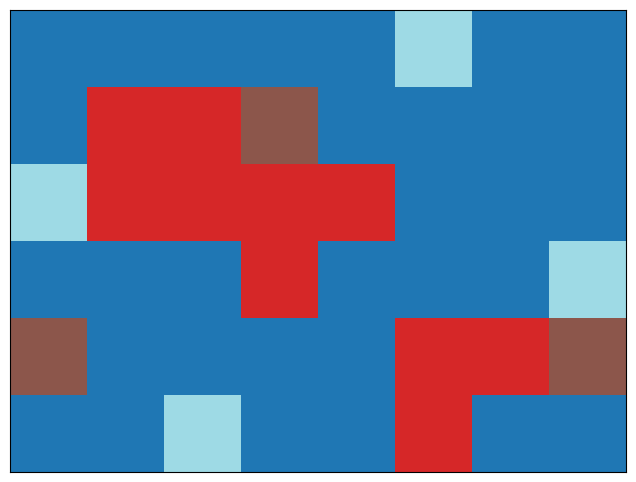

In [5]:
# PARÁMETROS
WIDTH = 8
HEIGHT = 6
FIREFIGHTERS = 6
FIRE = [(1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (2, 4), (3, 3), (4, 5), (4, 6), (5, 5)]
WALLS = [
    [[2, 0, 0, 2], [2, 0, 0, 0], [2, 'door', 0, 0], [2, 0, 0, 'door'], [2, 2, 0, 0], ['entrance', 0, 0, 2], [2, 0, 0, 0], [2, 2, 0, 0]],
    [[0, 0, 0, 2], [0, 0, 0, 0], [0, 2, 2, 0], [0, 0, 2, 2], [0, 'door', 2, 0], [0, 0, 2, 'door'], [0, 0, 2, 0], [0, 2, 'door', 0]],
    [[0, 0, 0, 'entrance'], [0, 'door', 0, 0], [2, 0, 0, 'door'], [2, 0, 0, 0], [2, 0, 0, 0], [2, 2, 0, 0], [2, 0, 0, 2], ['door', 2, 0, 0]],
    [[0, 0, 2, 2], [0, 2, 2, 0], [0, 0, 2, 2], [0, 0, 'door', 0], [0, 0, 2, 0], [0, 'door', 2, 0], [0, 0, 2, 'door'], [0, 'entrance', 2, 0]],
    [[2, 0, 0, 2], [2, 0, 0, 0], [2, 0, 0, 0], ['door', 0, 0, 0], [2, 2, 0, 0], [2, 0, 0, 2], [2, 2, 0, 0], [2, 2, 0, 2]],
    [[0, 0, 2, 2], [0, 0, 2, 0], [0, 0, 'entrance', 0], [0, 0, 2, 0], [0, 'door', 2, 0], [0, 0, 2, 'door'], [0, 'door', 2, 0], [0, 2, 2, 'door']]
]
DOORS = {
    (0, 2, 0, 3): False,
    (1, 4, 1, 5): False,
    (1, 7, 2, 7): False,
    (2, 1, 2, 2): False,
    (3, 3, 4, 3): False,
    (3, 5, 3, 6): False,
    (5, 4, 5, 5): False,
    (5, 6, 5, 7): False
}
DOORS_CONNECTED = {
    (0, 2): (0, 3),
    (0, 3): (0, 2),
    (1, 4): (1, 5),
    (1, 5): (1, 4),
    (1, 7): (2, 7),
    (2, 7): (1, 7),
    (2, 1): (2, 2),
    (2, 2): (2, 1),
    (3, 3): (4, 3),
    (4, 3): (3, 3),
    (3, 5): (3, 6),
    (3, 6): (3, 5),
    (5, 4): (5, 5),
    (5, 5): (5, 4),
    (5, 6): (5, 7),
    (5, 7): (5, 6)
}
ENTRANCES = [
    (0, 5),
    (2, 0),
    (3, 7),
    (5, 2)
]
# POI (y, x, victim?, revealed?)
POI = [
    (1, 3, True, False),
    (4, 0, False, False),
    (4, 7, True, False)
]
# SIMULACIÓN
for sim in range(1):
    model = OrderingModel(WIDTH, HEIGHT, FIREFIGHTERS, FIRE, WALLS, DOORS, DOORS_CONNECTED, ENTRANCES, POI)
    steps = 0
    while  model.damage < 24 and model.total_deseases < 4 and model.total_saved_victims < 7:
        model.step()
        steps += 1

    if model.damage >= 24:
        print("BUILDING COLAPSED")
        print("GAME OVER")
    elif model.total_deseases >= 3:
        print("4 DISEASES")
        print("GAME OVER")
    elif model.total_saved_victims >= 7:
        print("VICTORY!!!!")

    dataframe = model.datacollector.get_model_vars_dataframe()

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    patch = plt.imshow(dataframe.iloc[0][0], cmap=plt.cm.tab20)

    # Animación
    def animate(i):
        patch.set_data(dataframe.iloc[i][0])

    anim = animation.FuncAnimation(fig, animate, frames=len(dataframe))
    plt.show()

In [6]:
anim

C:\Users\calde\AppData\Local\Temp\ipykernel_16852\2580434408.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(dataframe.iloc[i][0])


In [12]:
from http.server import BaseHTTPRequestHandler, HTTPServer
import logging
import json

class Server(BaseHTTPRequestHandler):
    def __init__(self, *args, **kwargs):
        self.model = OrderingModel(WIDTH, HEIGHT, FIREFIGHTERS, FIRE, WALLS, DOORS, DOORS_CONNECTED, ENTRANCES, POI)
        super().__init__(*args, **kwargs) 
    
    def _set_response(self):
        self.send_response(200)
        self.send_header('Content-type', 'text/html')
        self.end_headers()
        
    def do_GET(self):
        if (self.path == '/map'):
            response = {
                "walls": self.model.walls_grid.tolist(),
                "fires": self.model.fires_grid.tolist()
            }

            self._set_response()
            self.wfile.write(str(response).encode('utf-8'))
        elif (self.path == '/step'):
            self.model.step()
            response = {
                "moves": self.model.moves
            }
            self._set_response()
            self.wfile.write(str(response).encode('utf-8'))


def run(server_class=HTTPServer, handler_class=Server, port=8585):
    logging.basicConfig(level=logging.INFO)
    server_address = ('', port)
    httpd = server_class(server_address, handler_class)
    logging.info("Starting httpd...\n") # HTTPD is HTTP Daemon!
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:   # CTRL+C stops the server
        pass
    httpd.server_close()
    logging.info("Stopping httpd...\n")

if __name__ == '__main__':
    run()

INFO:root:Starting httpd...

127.0.0.1 - - [02/Sep/2024 12:50:52] "GET /map HTTP/1.1" 200 -


[['smoke', 1, 7]]


127.0.0.1 - - [02/Sep/2024 12:50:54] "GET /step HTTP/1.1" 200 -
INFO:root:Stopping httpd...

